In [2]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [7]:
aqt_results = pd.read_csv("../data/AQT/QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

rc_data = aqt_results.xs("RC", level="Protocol")
aqt_times = rc_data.index.get_level_values("Time").unique()

# renormalize in the 1-excitation subspace; average emitter 2 and 3
rc_data_norm = rc_data.copy()
rc_data_norm[['1000', '0100', '0010', '0001']] = rc_data_norm[['1000', '0100', '0010', '0001']].divide(rc_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
rc_data_norm['avg_0100_0001'] = rc_data_norm[['0100', '0001']].mean(axis=1)

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

normed_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0001",
    "Cavity + Environment": "0010",
}

In [27]:
aqt_raw = aqt_results.xs("RAW", level="Protocol")

# renormalize in the 1-excitation subspace; average emitter 2 and 3
raw_data_norm = aqt_raw.copy()
raw_data_norm[['1000', '0100', '0010', '0001']] = raw_data_norm[['1000', '0100', '0010', '0001']].divide(raw_data_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
raw_data_norm['avg_0100_0001'] = raw_data_norm[['0100', '0001']].mean(axis=1)

In [11]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 201)

In [12]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

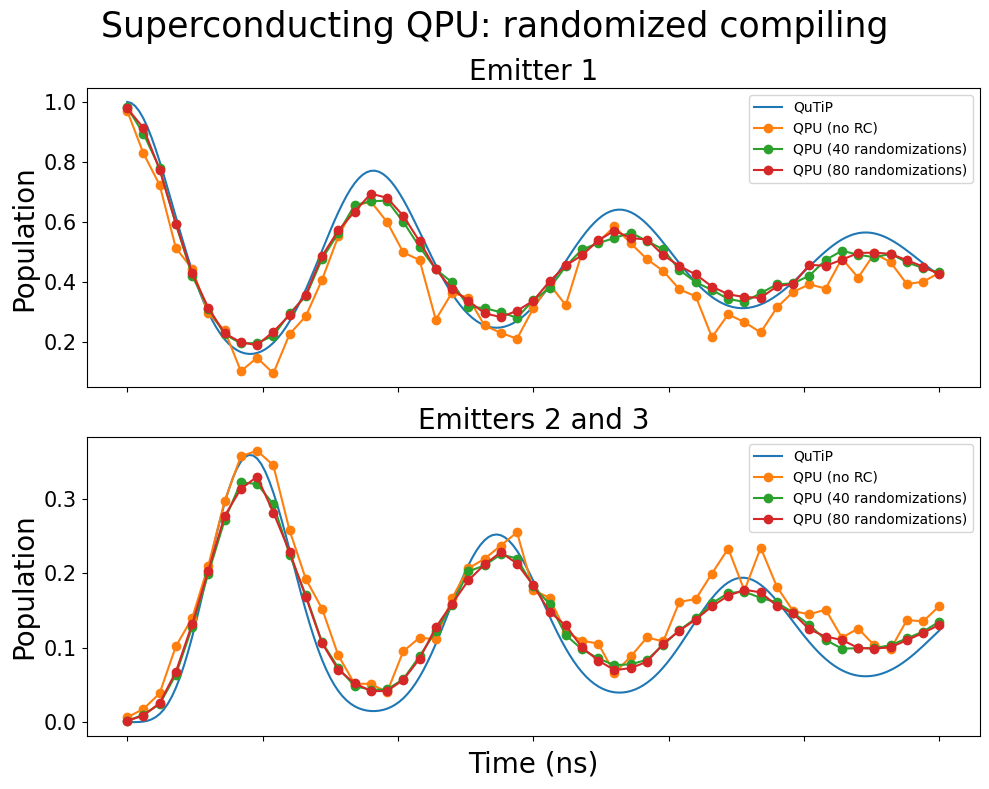

In [30]:
# Plot the RC data
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

rc_40 = rc_data_norm.xs(40, level="Randomizations")
rc_80 = rc_data_norm.xs(80, level="Randomizations")

axes[0].set_title("Emitter 1", fontsize=20)
axes[0].plot(times, qutip_results["Emitter 1"], label="QuTiP")
axes[0].plot(aqt_times, raw_data_norm[normed_bitstrs["Emitter 1"]], marker='o', label="QPU (no RC)")
axes[0].plot(aqt_times, rc_40[normed_bitstrs["Emitter 1"]], marker='o', label="QPU (40 randomizations)")
axes[0].plot(aqt_times, rc_80[normed_bitstrs["Emitter 1"]], marker='o', label="QPU (80 randomizations)")
axes[0].set_ylabel("Population", fontsize=20)
axes[0].legend()
axes[0].set_xticklabels([])
axes[0].tick_params(axis='y', labelsize=15)

axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].plot(times, qutip_results["Emitter 2"], label="QuTiP")
axes[1].plot(aqt_times, raw_data_norm[normed_bitstrs["Emitter 2 and 3"]], marker='o', label="QPU (no RC)")
axes[1].plot(aqt_times, rc_40[normed_bitstrs["Emitter 2 and 3"]], marker='o', label="QPU (40 randomizations)")
axes[1].plot(aqt_times, rc_80[normed_bitstrs["Emitter 2 and 3"]], marker='o', label="QPU (80 randomizations)")
axes[1].set_ylabel("Population", fontsize=20)
axes[1].legend()
axes[1].set_xticklabels([])
axes[1].tick_params(axis='y', labelsize=15)

axes[1].set_xlabel("Time (ns)", fontsize=20)

fig.suptitle("Superconducting QPU: randomized compiling", fontsize=25)
plt.tight_layout()


In [31]:
fig.savefig("../figures/AQT_RC.eps", bbox_inches="tight")